[[  0.   1.   0.   0.]
 [-10.  -4.   0.   0.]
 [  0.   0.   0.   1.]
 [  0.   0. -10.  -4.]]
(4, 4)
[[0 0 1 0]
 [0 0 0 1]
 [0 0 0 0]
 [0 0 0 0]]
[[0.1      0.       0.       0.      ]
 [0.       0.1      0.       0.      ]
 [0.       0.       0.003125 0.      ]
 [0.       0.       0.       0.003125]]
[[ -0.]
 [400.]
 [ -0.]
 [ -0.]]
[[-0.]
 [-0.]
 [-0.]
 [-0.]]


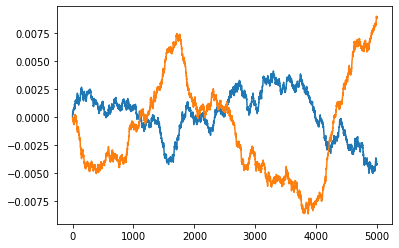

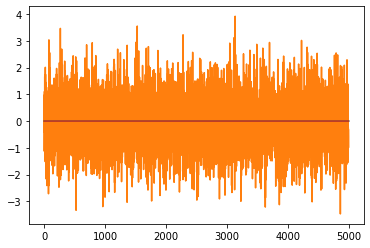

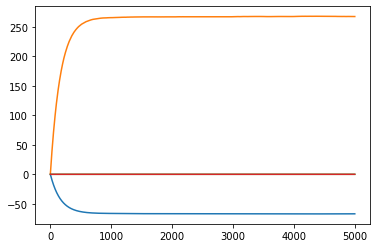

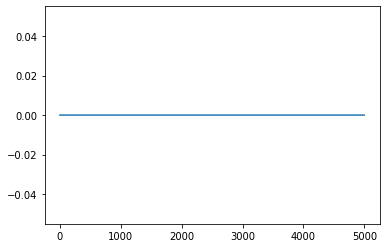

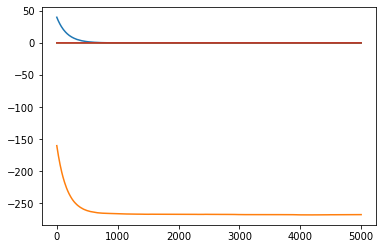

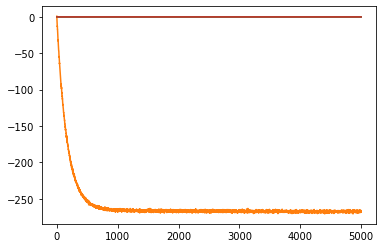

In [ ]:
# Python implementation of an active inference spring. Example 7 from sherin's thesis https://repository.tudelft.nl/islandora/object/uuid:0f56c37c-d22b-478b-8a85-dca615a8f419

import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as LA
m = 10
k=100
c = 40
alpha = 40
sigma_w = 10
sigma_z = 1
gamma = 16
p = 2
kappa = 10 #a learning rate of 10(!!)
rho = 1e4
N_steps = 5
N_grad_steps = 1
dt = 0.001
N = int(N_steps/dt)

#generative process
A = np.array([[0,1],[-k/m, -c/m]]).reshape(2,2)
B = np.array([0, 1/m]).reshape(2,1)
C = np.array([0,1]).reshape(2,1).T
sig_w = np.array([[1/sigma_w,0],[0,1/sigma_w]]).reshape(2,2)

#generative model
A_gm = np.array([[0,1,0,0],[-k/m,-c/m,0,0],[0,0,0,1],[0,0,-k/m,-c/m]]).reshape(4,4)
print(A_gm)
print(A_gm.shape)
B_gm = np.array([0,1/m,0,0]).reshape(4,1)           
C_gm = np.array([[0,0,0,0],[0,1,0,0],[0,0,0,0],[0,0,0,0]]).reshape(4,4)
D = np.array([[0,0,1,0],[0,0,0,1],[0,0,0,0],[0,0,0,0]]).reshape(4,4)
print(D)
pi_w = np.array([[1/sigma_w,0,0,0],[0,1/sigma_w,0,0],[0,0,1/(2 * sigma_w * gamma),0],[0,0,0,1/(2 * sigma_w * gamma)]]).reshape(4,4)
print(pi_w)
pi_z = 1/sigma_z
m_eq = np.array([alpha, 0,0,0]).reshape(4,1)
Z = -np.dot(A_gm, m_eq)
print(Z)
G = -np.dot(C_gm, np.dot(LA.inv(A_gm), B_gm))
print(G)
#for reshaping the ys correctly
C_reshp = np.array([0,1,0,0]).reshape(4,1)


x = np.array([0,0]).reshape(2,1)
y = np.dot(C,x)
mu = np.array([0,0,0,0]).reshape(4,1)
u = np.array([0]).reshape(1,1)

xs = []
ys = []
mus = []
us = []
exs = []
eys = []

#so with a rapid learning rate it can learn quickly, but is this interesting particularly?
for i in range(N):
  #print("epoch ",i)
  #update generative process
  xdot = np.dot(A,x) + np.dot(B,u) + np.dot(sig_w, np.random.normal(0,1,size=[2,1]))
  x = x + (dt * xdot)
  y = np.dot(C,x) + np.random.normal(0,1) * sigma_z
  y = np.dot(C_reshp,y)
  #update active inference filter
  for j in range(N_grad_steps):
    ey = y - np.dot(C_gm, mu)
    #ey = np.array([ey,0,0,0]).reshape(4,1)
    #print(ey.shape)
    ex = np.dot(D - A_gm, np.dot(pi_w, (np.dot(D,mu) - np.dot(A_gm, mu- m_eq))))
    #print(ex.shape)
    mudot = np.dot(D, mu) + kappa * ((sigma_z * ey) - ex)
    mu = mu + (dt * mudot)
  #update action
  udot = -rho * np.dot(G.T, pi_z * (y - np.dot(C_gm, mu)))
  u = u + (dt * udot)

  #append results
  xs.append(np.copy(x))
  ys.append(np.copy(y))
  mus.append(np.copy(mu))
  us.append(np.copy(u))
  exs.append(ex)
  eys.append(ey)

xs = np.array(xs)
ys = np.array(ys)
mus = np.array(mus)
us = np.array(us)
exs=np.array(exs)
eys = np.array(eys)
plt.plot(xs.reshape(N,2))
plt.show()
plt.plot(ys.reshape(N,4))
plt.show()
plt.plot(mus.reshape(N,4))
plt.show()
plt.plot(us.reshape(N,1))
plt.show()
plt.plot(exs.reshape(N,4))
plt.show()
plt.plot(eys.reshape(N,4))
plt.show()